In [1]:
import os
import pandas as pd
import numpy as np

import nibabel as nib
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.ndimage import binary_dilation, convolve

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, balanced_accuracy_score

In [2]:
def extract_mask(participant_df, selection, unique_keys=["participant_id", "session", "study"], check_uniqueness=True):
        _source_keys = participant_df[unique_keys].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        if check_uniqueness:
            assert len(set(_source_keys)) == len(_source_keys), f"Multiple identique identifiers found"
        _target_keys = selection[unique_keys].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        mask = _source_keys.isin(_target_keys).values.astype(bool)
        return mask

# Loading data

In [5]:
# Parameters
root = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/root"
interim = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/interim"
id_types = {"participant_id": str,
            "session": int,
            "acq": int,
            "run": int}

In [6]:
arr = np.load(os.path.join(interim, "ausz_t1mri_skeleton_data32.npy"), mmap_mode="r")
df = pd.read_csv(os.path.join(root, "ausz_t1mri_participants.csv"), dtype=id_types)
scheme = pd.read_csv(os.path.join(root, "stratified_10_fold_ausz.csv"), dtype=id_types)
print(f"Data shape : {arr.shape} | {len(df)} | {len(scheme)}")

m_vbm = nib.load(os.path.join(root, "mni_cerebrum-gm-mask_1.5mm.nii.gz"))
brain_mask_vbm = (m_vbm.get_fdata() != 0).astype(bool)
brain_mask_vbm_pad = np.pad(brain_mask_vbm, pad_width = ((3, 4), (3, 4), (3, 4)))

m_raw = nib.load(os.path.join(root, "mni_raw_brain-mask_1.5mm.nii.gz"))
brain_mask_raw = (m_raw.get_fdata() != 0).astype(bool)
brain_mask_raw_pad = np.pad(brain_mask_raw, pad_width = ((3, 4), (3, 4), (3, 4)))

print(f"Brain mask shape : {brain_mask_vbm.shape} (after padding : {brain_mask_vbm_pad.shape})")

Data shape : (98, 1, 128, 152, 128) | 98 | 98
Brain mask shape : (121, 145, 121) (after padding : (128, 152, 128))


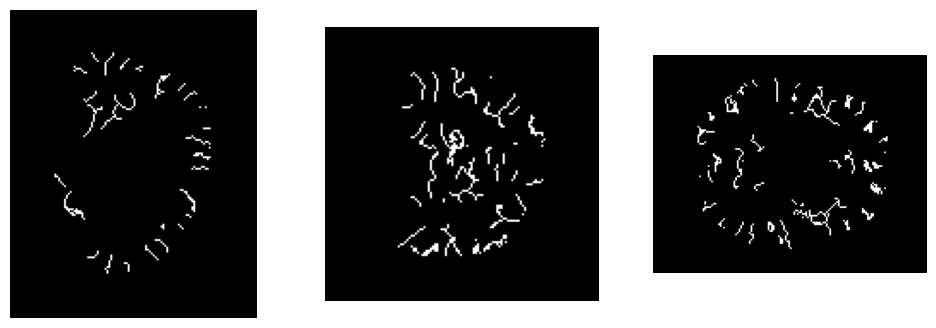

In [7]:
# Show skeleton images
i_img = 10
coord = (50, 50, 50)

imgs = np.load(os.path.join(root, "ausz_t1mri_skeleton_data32.npy"), mmap_mode="r")
img = imgs[i_img, 0, ...]
del imgs
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img[coord[0], ...], cmap="gray")
ax[0].set_axis_off()
ax[1].imshow(img[:, coord[1], :], cmap="gray")
ax[1].set_axis_off()
ax[2].imshow(img[..., coord[2]], cmap="gray")
ax[2].set_axis_off()
plt.show()

## Brain mask for skeletons

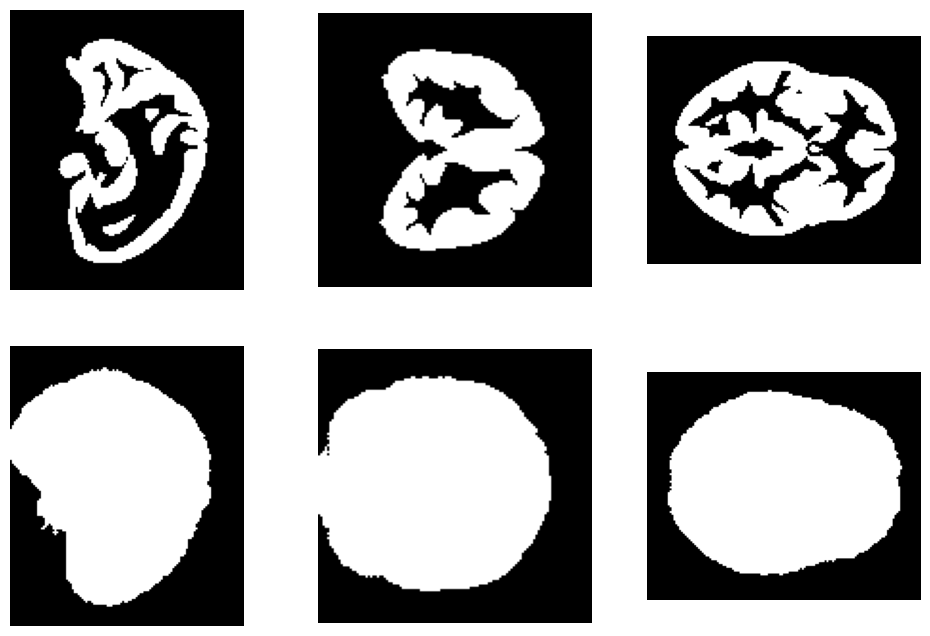

In [8]:
# Show brain masks
coord = (50, 50, 50)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(brain_mask_vbm[coord[0], ...], cmap="gray")
ax[0, 0].set_axis_off()
ax[0, 1].imshow(brain_mask_vbm[:, coord[1], :], cmap="gray")
ax[0, 1].set_axis_off()
ax[0, 2].imshow(brain_mask_vbm[..., coord[2]], cmap="gray")
ax[0, 2].set_axis_off()

ax[1, 0].imshow(brain_mask_raw[coord[0], ...], cmap="gray")
ax[1, 0].set_axis_off()
ax[1, 1].imshow(brain_mask_raw[:, coord[1], :], cmap="gray")
ax[1, 1].set_axis_off()
ax[1, 2].imshow(brain_mask_raw[..., coord[2]], cmap="gray")
ax[1, 2].set_axis_off()
plt.show()

### Selection of dilatation parameter

In [24]:
skeleton_map = (arr > 0).sum(axis=(0, 1)).astype(int)
print(skeleton_map.shape)

(128, 152, 128)


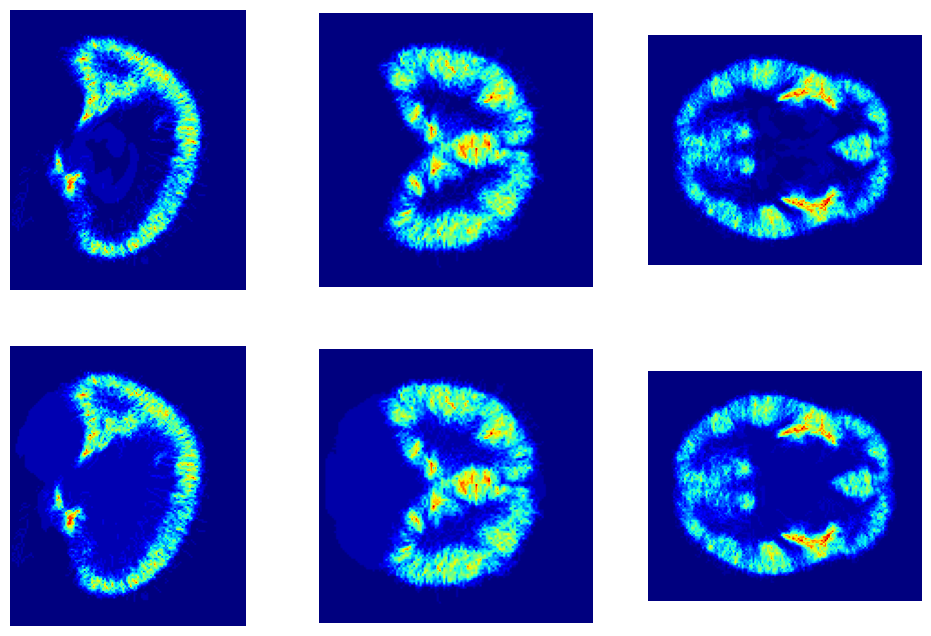

In [25]:
coord = (50, 50, 50)
threshold = skeleton_map.max()

img = skeleton_map
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(img[coord[0], ...] + brain_mask_vbm_pad[coord[0], ...], cmap="jet")
ax[0, 0].set_axis_off()
ax[0, 1].imshow(img[:, coord[1], :] + brain_mask_vbm_pad[:, coord[1], :], cmap="jet")
ax[0, 1].set_axis_off()
ax[0, 2].imshow(img[..., coord[2]] + brain_mask_vbm_pad[..., coord[2]], cmap="jet")
ax[0, 2].set_axis_off()

ax[1, 0].imshow(img[coord[0], ...] + brain_mask_raw_pad[coord[0], ...], cmap="jet")
ax[1, 0].set_axis_off()
ax[1, 1].imshow(img[:, coord[1], :] + brain_mask_raw_pad[:, coord[1], :], cmap="jet")
ax[1, 1].set_axis_off()
ax[1, 2].imshow(img[..., coord[2]] + brain_mask_raw_pad[..., coord[2]], cmap="jet")
ax[1, 2].set_axis_off()
plt.show()

  brain_mask  iteration_dilation  brain_mask_size  proportions_of_skeleton_map
0        vbm                   0           331695                     0.741796
1        vbm                   1           400467                     0.839396
2        vbm                   2           456849                     0.899137
3        vbm                   3           505288                     0.937618
4        vbm                   4           547964                     0.962856


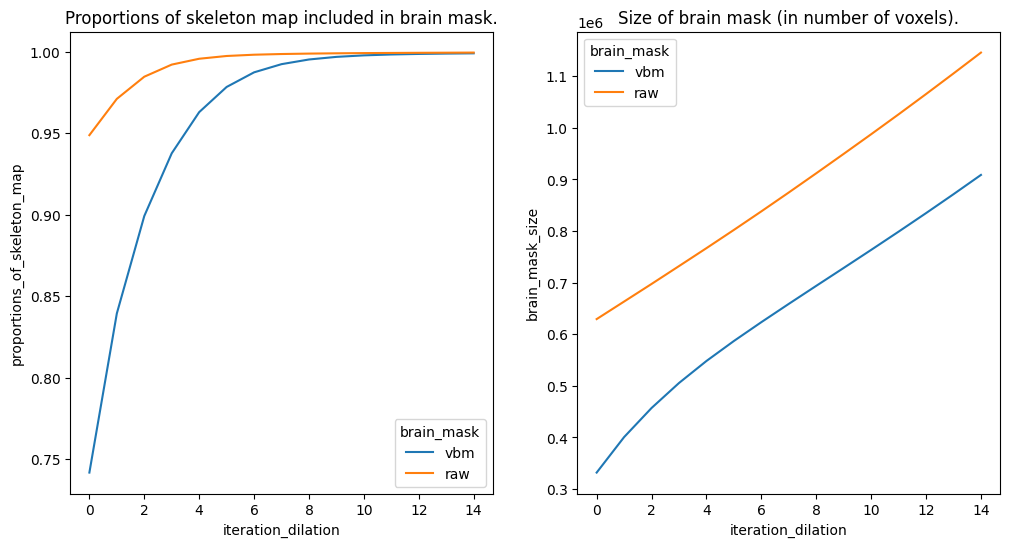

In [26]:
data = defaultdict(list)

for name, brain_mask_pad in zip(["vbm", "raw"], [brain_mask_vbm_pad, brain_mask_raw_pad]):
    for i in range(15):
        if i == 0:
            brain_mask_size = brain_mask_pad.sum()
            proportions_of_skeleton_map = skeleton_map[brain_mask_pad].sum() / skeleton_map.sum()
        else:
            brain_mask_dil = binary_dilation(brain_mask_pad, iterations=i, border_value=0, origin=0)
            proportions_of_skeleton_map = skeleton_map[brain_mask_dil].sum() / skeleton_map.sum()
            brain_mask_size = brain_mask_dil.sum()
        data["brain_mask"].append(name)
        data["iteration_dilation"].append(i)
        data["brain_mask_size"].append(brain_mask_size)
        data["proportions_of_skeleton_map"].append(proportions_of_skeleton_map)

data_df = pd.DataFrame(data)
print(data_df.head())
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(data=data_df, x="iteration_dilation", y="proportions_of_skeleton_map", hue="brain_mask", ax=ax[0])
ax[0].set_title("Proportions of skeleton map included in brain mask.")
sns.lineplot(data=data_df, x="iteration_dilation", y="brain_mask_size", hue="brain_mask", ax=ax[1])
ax[1].set_title("Size of brain mask (in number of voxels).")

plt.show()

We selected vbm mask with a coefficient of dilation of 4 to keep more than 95% of voxels of skeletons.

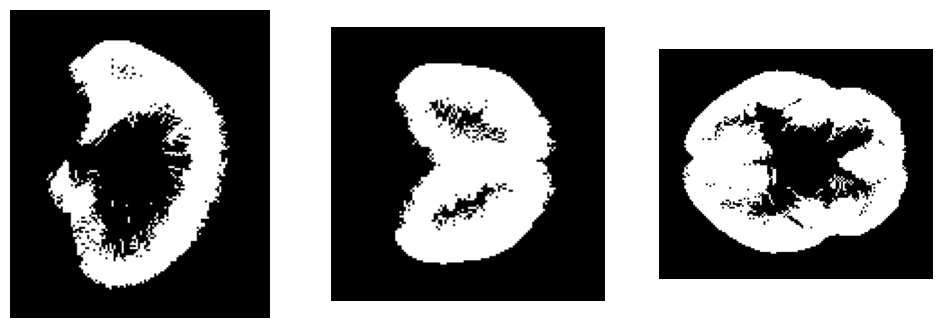

In [27]:
coord = (50, 50, 50)

iteration = 4
brain_mask_dil = binary_dilation(brain_mask_vbm_pad, iterations=iteration, border_value=0, origin=0)

img = (skeleton_map > 0).astype(int)
img[~brain_mask_dil] = 0
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img[coord[0], ...], cmap="gray")
ax[0].set_axis_off()
ax[1].imshow(img[:, coord[1], :], cmap="gray")
ax[1].set_axis_off()
ax[2].imshow(img[..., coord[2]], cmap="gray")
ax[2].set_axis_off()
plt.show()

## Smooth array

In [6]:
def make_gaussian_kernel(size, sigma):
    """ Create a gaussian kernel with size and sigma
    """
    half_size = size // 2
    rng = np.arange(-half_size, half_size + 1, 1)
    x, y, z = np.meshgrid(rng, rng, rng)
    kernel = np.exp(-(x ** 2 + y ** 2 + z ** 2) / (2 * sigma ** 2))
    return kernel.astype(np.float32)

def smoothing(arr, size, sigma):
    """ Convolution of an array with a gaussian kernel
    """
    kernel = make_gaussian_kernel(size=size, sigma=sigma)
    gauss_arr = convolve(arr, kernel, mode='constant', cval=0.0, origin=0)
    return gauss_arr

In [8]:
smoothed_arr = np.zeros_like(arr)
for i, r in enumerate(arr):
    smoothed_arr[i, 0, :] = smoothing(r[0, :], size=5, sigma=1.0)

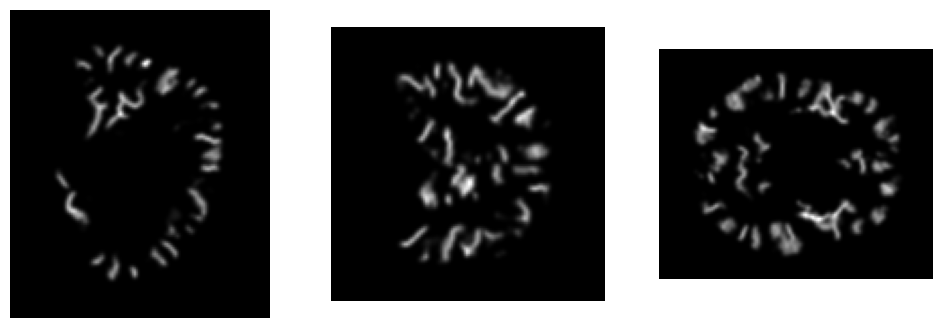

In [9]:
# Show smoothed skeleton images
i_img = 10
coord = (50, 50, 50)

img = smoothed_arr[i_img, 0, ...]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img[coord[0], ...], cmap="gray")
ax[0].set_axis_off()
ax[1].imshow(img[:, coord[1], :], cmap="gray")
ax[1].set_axis_off()
ax[2].imshow(img[..., coord[2]], cmap="gray")
ax[2].set_axis_off()
plt.show()

#### Little check

  brain_mask  iteration_dilation  brain_mask_size  proportions_of_skeleton_map
0        vbm                   0           331695                     0.639161
1        vbm                   1           400467                     0.744672
2        vbm                   2           456849                     0.816998
3        vbm                   3           505288                     0.868835
4        vbm                   4           547964                     0.907899


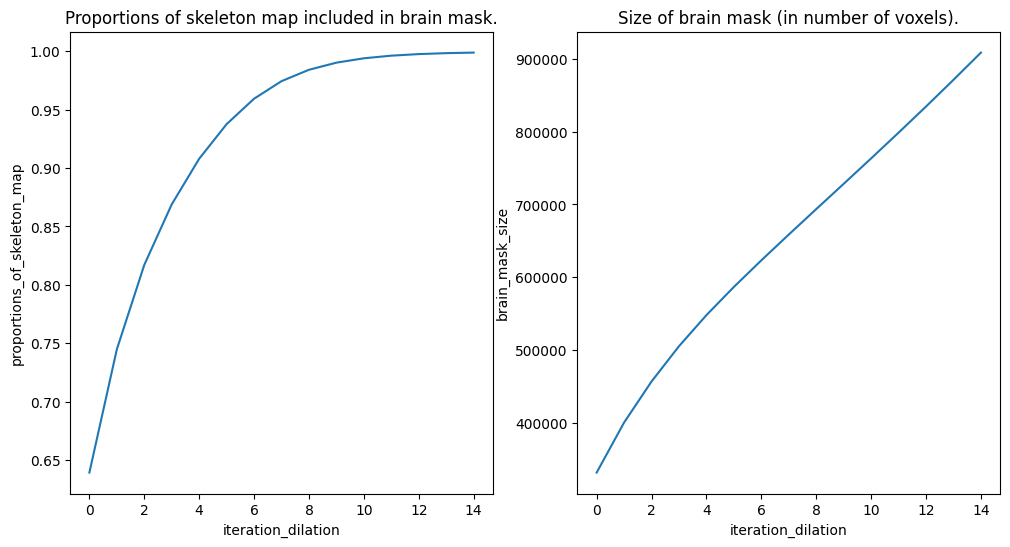

In [28]:
smoothed_skel_map = (smoothed_arr > 0).astype(int).sum(axis=(0, 1))

data = defaultdict(list)
name = " vbm"
brain_mask_pad = brain_mask_vbm_pad
for i in range(15):
    if i == 0:
        brain_mask_size = brain_mask_pad.sum()
        proportions_of_skeleton_map = smoothed_skel_map[brain_mask_pad].sum() / smoothed_skel_map.sum()
    else:
        brain_mask_dil = binary_dilation(brain_mask_pad, iterations=i, border_value=0, origin=0)
        proportions_of_skeleton_map = smoothed_skel_map[brain_mask_dil].sum() / smoothed_skel_map.sum()
        brain_mask_size = brain_mask_dil.sum()
    data["brain_mask"].append(name)
    data["iteration_dilation"].append(i)
    data["brain_mask_size"].append(brain_mask_size)
    data["proportions_of_skeleton_map"].append(proportions_of_skeleton_map)

data_df = pd.DataFrame(data)
print(data_df.head())
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(data=data_df, x="iteration_dilation", y="proportions_of_skeleton_map", ax=ax[0])
ax[0].set_title("Proportions of skeleton map included in brain mask.")
sns.lineplot(data=data_df, x="iteration_dilation", y="brain_mask_size", ax=ax[1])
ax[1].set_title("Size of brain mask (in number of voxels).")

plt.show()

## Final preprocessing of data

In [12]:
# final brain mask
final_brain_mask = binary_dilation(brain_mask_vbm_pad, iterations=4, border_value=0, origin=0)
# reshaping data with final brain mask
arr = arr[:, 0, final_brain_mask]
# binarize array
arr = (arr > 0).astype(float)
print("Array shape", arr.shape)

Array shape (98, 547964)


In [13]:
# final brain mask
final_brain_mask = binary_dilation(brain_mask_vbm_pad, iterations=6, border_value=0, origin=0)
# reshaping data with final brain mask
smoothed_arr = smoothed_arr[:, 0, final_brain_mask]
smoothed_arr = smoothed_arr.astype(float)
print("Array shape", smoothed_arr.shape)

Array shape (98, 547964)


# Predictions of NSS scores

## With raw  array

In [23]:
# Parameters
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20240718_ridge"
n_jobs = 10
label = "NSS"
nb_folds=10

os.makedirs(saving_dir, exist_ok=True)
logs = defaultdict(list)

In [24]:
for fold in range(nb_folds):
    # 0) Load data
    train_selection = scheme.loc[scheme[f"fold{fold}"] == "train", ["participant_id", "session", "study"]]
    train_mask = extract_mask(df, train_selection)
    #print(train_mask.shape)
    train_data = arr[train_mask]
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    test_selection = scheme.loc[scheme[f"fold{fold}"] == "test", ["participant_id", "session", "study"]]
    test_mask = extract_mask(df, test_selection)
    test_data = arr[test_mask]
    y_test = df.loc[test_mask, label].values.astype(np.float32)
    #print(f"Train data shape : {train_data.shape} | {y_train.shape}")
    #print(f"Test data shape : {test_data.shape} | {y_test.shape}")
    

    # 1) Normalization : no normalization need with skeletons   
    """
    scaler = StandardScaler
    ss = scaler().fit(train_data)
    train_data_ = ss.transform(train_data)
    test_data_ = ss.transform(test_data)
    """

    # 2) Training    
    #model = Ridge(alpha=0.1, fit_intercept=True, solver="auto")
    #model.fit(train_data, y_train)
    hyperparams = {'alpha': [1e-1, 1, 10, 10**2, 10**3], 
                    'fit_intercept': [True],
                    'solver': ['auto']}
    model_cv = GridSearchCV(Ridge(), hyperparams, refit=True, n_jobs=n_jobs, scoring="neg_mean_absolute_error", cv=3)
    model_cv.fit(train_data, y_train)
    best_score, best_params = model_cv.best_score_, model_cv.best_params_
    print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    #y_pred_test = model.predict(test_data)
    #r2 = model.score(test_data, y_test)
    y_pred_test = model_cv.predict(test_data)
    r2 = model_cv.best_estimator_.score(test_data, y_test)
    rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
    mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving
    for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
        logs["fold"].append(fold)
        logs["alpha"].append(best_params["alpha"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)
    np.save(os.path.join(saving_dir, f"nss_pred_test_fold-{fold}.npy"), y_pred_test)

Model train - best score : -6.3 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.8 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.6 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.1 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.2 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.9 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.2 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.8 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6 | best params : {'alpha': 0.1, '

In [25]:
# Saving
logs_df = pd.DataFrame(logs)
logs_df.to_csv(os.path.join(saving_dir, "results_predictions_nss.csv"), sep=",", index=False)

In [117]:
logs_df.head()

,fold,alpha,split,metric,value
0,0,1000.0,test,r2,-0.197466
1,0,1000.0,test,rmse,5.039668
2,0,1000.0,test,mae,4.056991
3,1,0.1,test,r2,-0.253822
4,1,0.1,test,rmse,7.513336


Display Results

In [26]:
results = pd.read_csv(os.path.join(saving_dir, "results_predictions_nss.csv"), sep=",")

In [27]:
results[["metric", "value"]].groupby("metric").describe()

value                                                              \
       count      mean       std       min       25%       50%       75%   
metric                                                                     
mae     10.0  5.920697  1.592908  3.450212  4.574526  6.245947  6.940494   
r2      10.0 -0.234083  0.459584 -1.511253 -0.191824 -0.113251 -0.022266   
rmse    10.0  7.217341  2.224196  4.719293  5.382629  7.080749  7.966970   

                   
              max  
metric             
mae      8.373566  
r2       0.062121  
rmse    12.078729

In [114]:
model_cv.best_estimator_.coef_.shape

(547964,)

## With smooth array

Training Model

In [10]:
# Parameters
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20240903_ridge_with_smoothing"
n_jobs = 10
label = "NSS"
nb_folds=10

os.makedirs(saving_dir, exist_ok=True)
logs = defaultdict(list)

In [38]:
for fold in range(nb_folds):
    # 0) Load data
    train_selection = scheme.loc[scheme[f"fold{fold}"] == "train", ["participant_id", "session", "study"]]
    train_mask = extract_mask(df, train_selection)
    #print(train_mask.shape)
    train_data = smoothed_arr[train_mask]
    y_train = df.loc[train_mask, label].values.astype(np.float32)

    test_selection = scheme.loc[scheme[f"fold{fold}"] == "test", ["participant_id", "session", "study"]]
    test_mask = extract_mask(df, test_selection)
    test_data = smoothed_arr[test_mask]
    y_test = df.loc[test_mask, label].values.astype(np.float32)
    #print(f"Train data shape : {train_data.shape} | {y_train.shape}")
    #print(f"Test data shape : {test_data.shape} | {y_test.shape}")
    

    # 1) Normalization : no normalization need with skeletons   
    scaler = StandardScaler
    ss = scaler().fit(train_data)
    # train_data = ss.transform(train_data)
    # test_data = ss.transform(test_data)

    # 2) Training    
    #model = Ridge(alpha=0.1, fit_intercept=True, solver="auto")
    #model.fit(train_data, y_train)
    hyperparams = {'alpha': [1e-1, 1, 10, 10**2, 10**3], 
                    'fit_intercept': [True],
                    'solver': ['auto']}
    model_cv = GridSearchCV(Ridge(), hyperparams, refit=True, n_jobs=n_jobs, scoring="neg_mean_absolute_error", cv=3)
    model_cv.fit(train_data, y_train)
    best_score, best_params = model_cv.best_score_, model_cv.best_params_
    print(f"Model train - best score : {best_score:.2g} | best params : {best_params}")

    # 3) Testing
    #y_pred_test = model.predict(test_data)
    #r2 = model.score(test_data, y_test)
    y_pred_test = model_cv.predict(test_data)
    r2 = model_cv.best_estimator_.score(test_data, y_test)
    rmse = mean_squared_error(y_pred=y_pred_test, y_true=y_test, squared=False) 
    mae = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)

    # 4) Saving
    for metric, value in zip(["r2", "rmse", "mae"], [r2, rmse, mae]):
        logs["fold"].append(fold)
        logs["alpha"].append(best_params["alpha"])
        logs["split"].append("test")
        logs["metric"].append(metric)
        logs["value"].append(value)
    np.save(os.path.join(saving_dir, f"nss_pred_test_fold-{fold}.npy"), y_pred_test)

Model train - best score : -6.2 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.6 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.7 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.1 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.1 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.9 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.2 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -5.8 | best params : {'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6.1 | best params : {'alpha': 1000, 'fit_intercept': True, 'solver': 'auto'}
Model train - best score : -6 | best params : {'alpha': 0.1

In [40]:
# Saving
logs_df = pd.DataFrame(logs)
logs_df.to_csv(os.path.join(saving_dir, "results_predictions_nss.csv"), sep=",", index=False)

In [11]:
# Display results
results = pd.read_csv(os.path.join(saving_dir, "results_predictions_nss.csv"), sep=",")
results[["metric", "value"]].groupby("metric").describe()

value                                                              \
       count      mean       std       min       25%       50%       75%   
metric                                                                     
mae     10.0  5.856307  1.613761  2.997106  5.174108  6.343940  6.797981   
r2      10.0 -0.255657  0.569376 -1.669751 -0.398523 -0.064253  0.065876   
rmse    10.0  7.171549  2.120971  4.216164  6.073544  7.018562  8.147100   

                   
              max  
metric             
mae      8.370280  
r2       0.251438  
rmse    11.586428

In [12]:
df_pred = df[["participant_id", "age", "sex", "diagnosis", "NSS"]].copy(deep=True)
for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred"] = np.load(os.path.join(saving_dir, f"nss_pred_test_fold-{fold}.npy"))

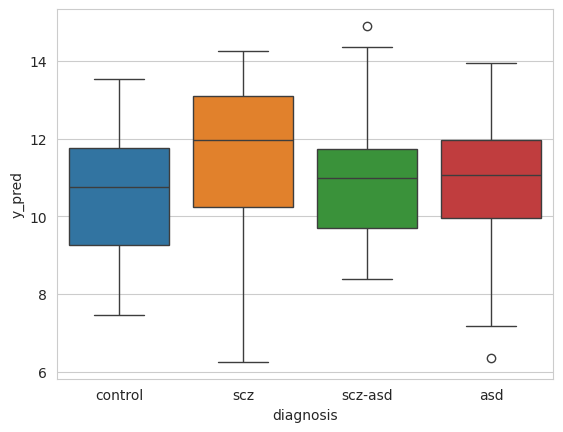

In [13]:
with sns.axes_style("whitegrid"):
    sns.boxplot(data=df_pred, x="diagnosis", y="y_pred", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

In [15]:
data = defaultdict(list)
for diag in ("control", "scz", "scz-asd", "asd"):
    
    r2 = r2_score(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                           y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    mae = mean_absolute_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    rmse = mean_squared_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'],
                                       squared=False)
    print(f"# {diag}")
    print(f"R2:", r2)
    print(f"MAE:", mae)
    print(f"RMSE:", rmse)

    data["diagnosis"].append(diag)
    data["r2"].append(r2)
    data["mean_absolute_error"].append(mae)
    data["root_mean_squared_error"].append(rmse)
data_df = pd.DataFrame(data)

# control
R2: -1.6195158760791855
MAE: 5.41968950498079
RMSE: 6.38341795114573
# scz
R2: -0.037566721167230144
MAE: 5.357996495443549
RMSE: 5.994769318790929
# scz-asd
R2: 0.03988597474790667
MAE: 5.526924017558569
RMSE: 8.143849002735223
# asd
R2: -1.1682958571044644
MAE: 7.123414081778194
RMSE: 9.022074399809702


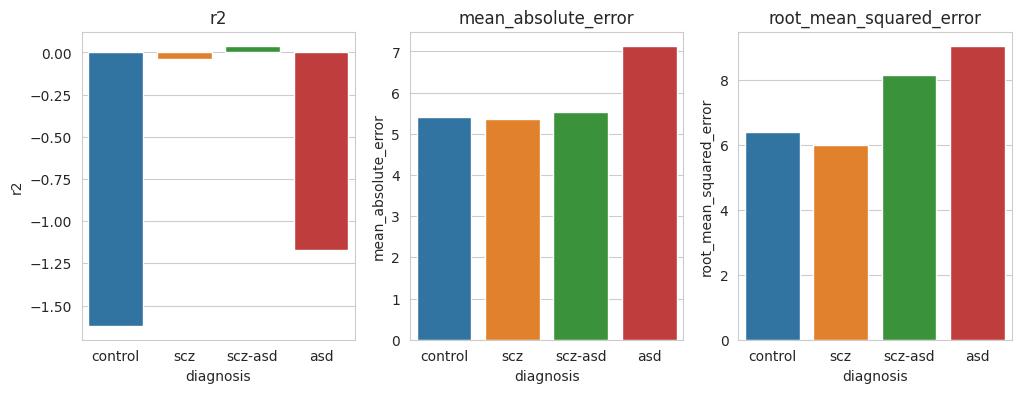

In [17]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(4*3, 4))
    for i, metric in enumerate(["r2", "mean_absolute_error", "root_mean_squared_error"]):
        sns.barplot(data=data_df, x="diagnosis", y=metric, order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[i])
        ax[i].set_title(metric)
plt.show()

# Predictions of other metadata

In [36]:
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20240903_ridge_with_smoothing"
nb_folds = 10

Index(['participant_id', 'session', 'run', 'sex', 'age', 'diagnosis', 'tiv',
       'skeleton_size', 'site', 'study',
       ...
       'DTD_1_AUTOQ_ITM_25_E1_C50', 'DTD_1_AUTOQ_ITM_26_E1_C50',
       'DTD_1_AUTOQ_ITM_27_E1_C50', 'DTD_1_AUTOQ_ITM_28_E1_C50', 'DTDrelat',
       'DTDcomm', 'DTDcomp', 'DTDdvpt', 'DTDTSA', 'DTDtot'],
      dtype='object', length=161)

In [37]:
mapping = {
    "M": 0,
    "m": 0,
    "F": 1,
    "control": 0,
    "scz": 1,
    "scz-asd": 1,
    "asd": 1
}

In [45]:
logs = defaultdict(list)

for fold in range(nb_folds):
    print(f"\nFold {fold}")

    # 0) Load data
    train_selection = scheme.loc[scheme[f"fold{fold}"] == "train", ["participant_id", "session", "study"]]
    train_mask = extract_mask(df, train_selection)
    train_data = smoothed_arr[train_mask]
    y_train = df.loc[train_mask, label]

    test_selection = scheme.loc[scheme[f"fold{fold}"] == "test", ["participant_id", "session", "study"]]
    test_mask = extract_mask(df, test_selection)
    test_data = smoothed_arr[test_mask]
    y_test = df.loc[test_mask, label]

    # 1) Normalization : no normalization need with skeletons   
    scaler = StandardScaler
    ss = scaler().fit(train_data)
    train_data_ = ss.transform(train_data)
    test_data_ = ss.transform(test_data)

    # 2) Training
    for label in ["sex", "age", "diagnosis", "tiv", "skeleton_size"]:

        y_train = df.loc[train_mask, label]
        y_test = df.loc[test_mask, label]

        if label in ["sex", "diagnosis"]:
            y_train = y_train.replace(mapping).values.astype(int)
            y_test = y_test.replace(mapping).values.astype(int)

            model = LogisticRegression(C=1.0, max_iter=1000, solver="sag", penalty="l2", fit_intercept=True, class_weight="balanced")
            

            metrics = {
                "roc_auc": lambda y_pred, y_true: roc_auc_score(y_true=y_true, y_score=y_pred[:, 1]),
                "bacc": lambda y_pred, y_true: balanced_accuracy_score(y_true=y_true, y_pred=(y_pred[:, 1] > 0.5).astype(int))
            }
        else:
            y_train = y_train.values.astype(np.float32)
            y_test = y_test.values.astype(np.float32)

            model = Ridge(alpha=0.1, fit_intercept=True, solver="auto")

            metrics = {
                "r2": r2_score,
                "rmse": lambda y_pred, y_true: mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False),
                "mae": mean_absolute_error
            }
    
        model.fit(train_data, y_train)

        # 3) Testing
        print(f"Label: {label} - score: {model.score(test_data, y_test)}")
        if label in ["sex", "diagnosis"]:
            y_pred_test = model.predict_proba(test_data)
        else:
            y_pred_test = model.predict(test_data)

        for name, metric in metrics.items():
            if (fold == 1) & (label == "sex") & (name == "roc_auc"):
                continue
            value = metric(y_true=y_test, y_pred=y_pred_test)
            logs["label"].append(label)
            logs["fold"].append(fold)
            logs["split"].append("test")
            logs["metric"].append(name)
            logs["value"].append(value)

# Saving
logs_df = pd.DataFrame(logs)
logs_df.to_csv(os.path.join(saving_dir, "results_predictions_metadata.csv"), sep=",", index=False)


Fold 0
Label: sex - score: 0.8
Label: age - score: 0.02206459434304575


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Label: diagnosis - score: 0.3
Label: tiv - score: 0.2239400333004301
Label: skeleton_size - score: 0.5473137042911803

Fold 1


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Label: sex - score: 1.0
Label: age - score: -0.06048728746250087


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Label: diagnosis - score: 0.6
Label: tiv - score: 0.03274624445657026
Label: skeleton_size - score: 0.5143696092340408

Fold 2
Label: sex - score: 0.8888888888888888
Label: age - score: -0.38164366082529133


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Label: diagnosis - score: 0.7777777777777778
Label: tiv - score: 0.07573027290235324
Label: skeleton_size - score: 0.48126410194343594

Fold 3


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Label: sex - score: 0.9
Label: age - score: -1.0989341347644896


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Label: diagnosis - score: 0.8
Label: tiv - score: -0.026204823401358546
Label: skeleton_size - score: 0.45219050834756813

Fold 4
Label: sex - score: 0.9
Label: age - score: -0.4363942287799847


/neurospin/dico/pauriau/envs/nss/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Label: diagnosis - score: 0.7
Label: tiv - score: 0.28087245666961036
Label: skeleton_size - score: 0.34852614749557587

Fold 5
Label: sex - score: 0.8
Label: age - score: 0.16741695179702965


In [38]:
predictions_df = pd.read_csv(os.path.join(saving_dir, "skeleton_all_predictions.csv"))

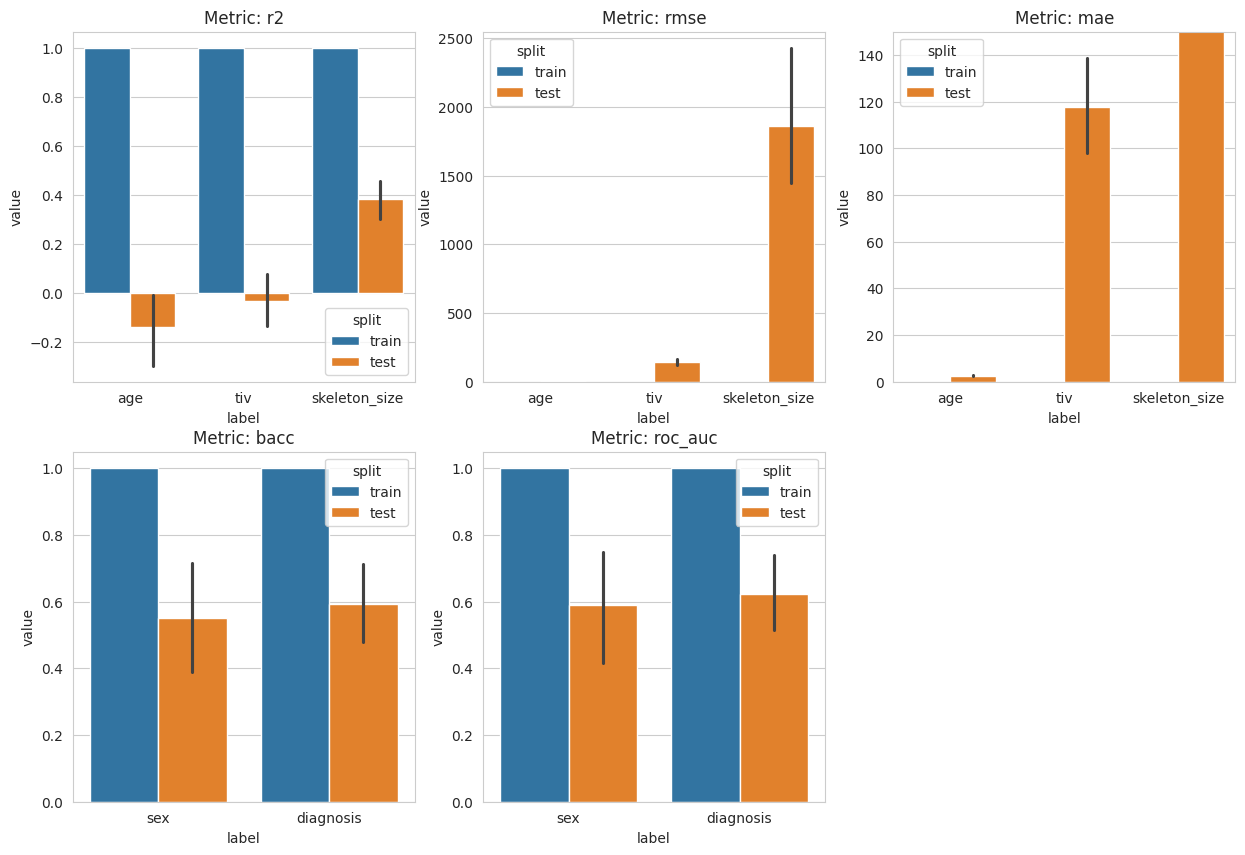

In [45]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=predictions_df[(predictions_df["metric"] == metric) & (predictions_df["fold"] != 6)], x="label", y="value", hue="split", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 2].set(ylim=(0, 150))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=predictions_df[(predictions_df["metric"] == metric)], x="label", y="value", hue="split", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()

Conclusions :
* **There are errors in the computation of skeleton size in the test set of fold 6**
* Predictions are as expected :
    * good for skeleton size and diagnosis
    * all right for sex
    * bad for age and tiv

# Predictions with random permutations

In [14]:
saving_dir =  "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20240924_nss_predictions_random_permutations"
n_permutations = 1000

In [15]:
df_test = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-skeleton_model-lrl2_permutation-{i}.csv")) for i in range(n_permutations+1)], axis=0)

In [16]:
df_test.head()

,label,fold,split,metric,value
0,permutation-0,0,train,r2,0.999410
1,permutation-0,0,train,rmse,0.186273
2,permutation-0,0,train,mae,0.148819
3,permutation-0,0,test,r2,-0.082671
4,permutation-0,0,test,rmse,4.792019


In [17]:
df_test["target"] = df_test["label"].apply(lambda l: "random" if l != "permutation-0" else "scores")

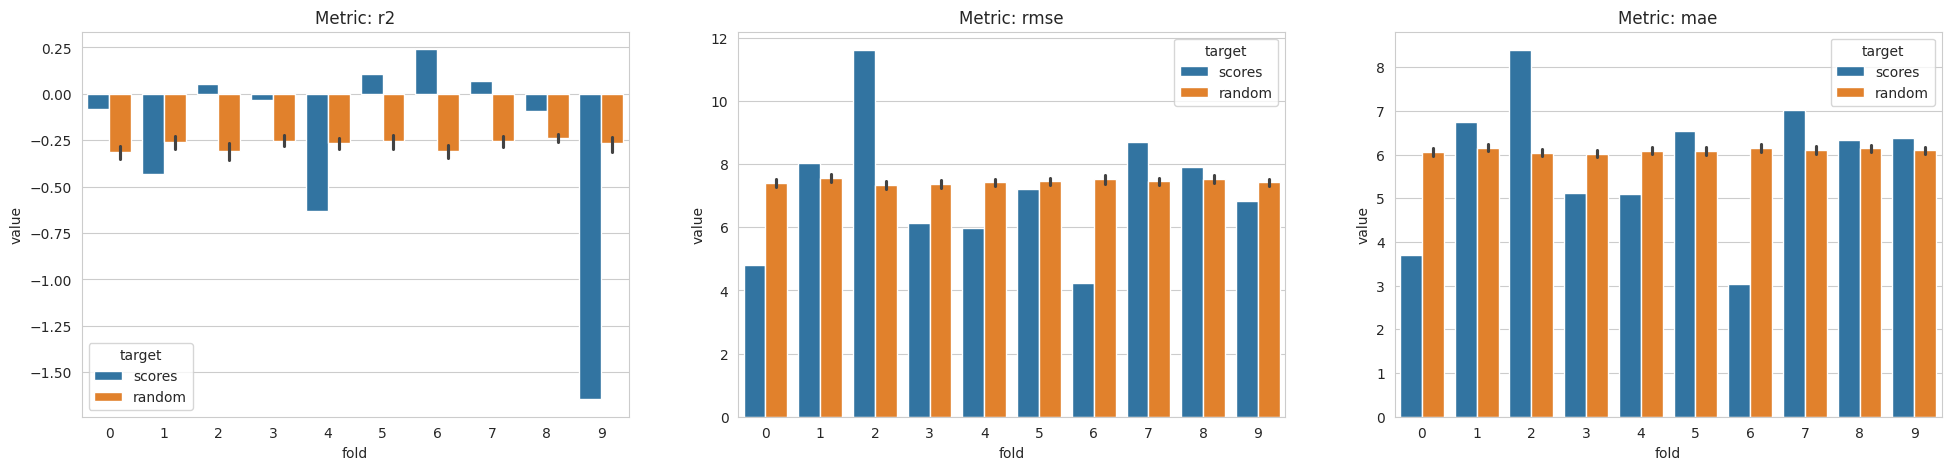

In [18]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(8*3, 5*1))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=df_test[(df_test["metric"] == metric) & (df_test["split"] == "test")], x="fold", y="value", hue="target", ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")

    plt.show()

# Predictions with new stratification (with NSS score, sex and age)

In [5]:
# Loading data
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20241001_nss_sex_age_stratification_no_scaler"
scheme = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed/nss_sex_age_stratified_10_fold_ausz.csv", sep=",")
df = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/without_nss_scores_from_tableau/processed/ausz_t1mri_participants.csv", sep=",")
preproc = "skeleton"
nb_folds = 10

## NSS predictions

In [6]:
label = "NSS"
results = pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-lrl2_label-{label}.csv"), sep=",")
results.loc[results["split"] == "test", ["metric", "value"]].groupby("metric").describe()

value                                                              \
       count      mean       std       min       25%       50%       75%   
metric                                                                     
mae     10.0  5.834031  1.431135  4.180320  4.603550  5.810042  6.787190   
r2      10.0 -0.099754  0.192104 -0.402742 -0.235772 -0.013551  0.045789   
rmse    10.0  7.191356  2.106693  5.013683  5.441581  7.067138  8.077180   

                   
              max  
metric             
mae      8.614779  
r2       0.127252  
rmse    11.943911

In [7]:
df_pred = df[["participant_id", "age", "sex", "diagnosis", "NSS"]].copy(deep=True)
for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-{preproc}_fold-{fold}.npy"))

In [8]:
print(df_pred["y_pred"].min(), df_pred["y_pred"].max(), df_pred["y_pred"].mean(), df_pred["y_pred"].std())

7.0892487 15.018709 11.098395 1.8779743


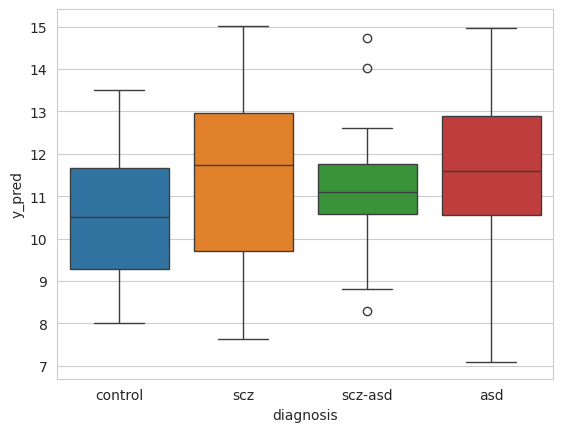

In [9]:
with sns.axes_style("whitegrid"):
    sns.boxplot(data=df_pred, x="diagnosis", y="y_pred", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

In [10]:
data = defaultdict(list)
for diag in ("control", "scz", "scz-asd", "asd"):
    
    r2 = r2_score(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                           y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    mae = mean_absolute_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    rmse = mean_squared_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'],
                                       squared=False)
    print(f"# {diag}")
    print(f"R2:", r2)
    print(f"MAE:", mae)
    print(f"RMSE:", rmse)

    data["diagnosis"].append(diag)
    data["r2"].append(r2)
    data["mean_absolute_error"].append(mae)
    data["root_mean_squared_error"].append(rmse)
data_df = pd.DataFrame(data)

# control
R2: -2.342689019764632
MAE: 5.674216912342952
RMSE: 6.571376789807154
# scz
R2: 0.029820354502924862
MAE: 4.9705214103062945
RMSE: 5.781789452936786
# scz-asd
R2: 0.04918695040886367
MAE: 5.501995611190796
RMSE: 8.104306783009372
# asd
R2: -0.9347660468412688
MAE: 6.6947416305542
RMSE: 8.522389183698502


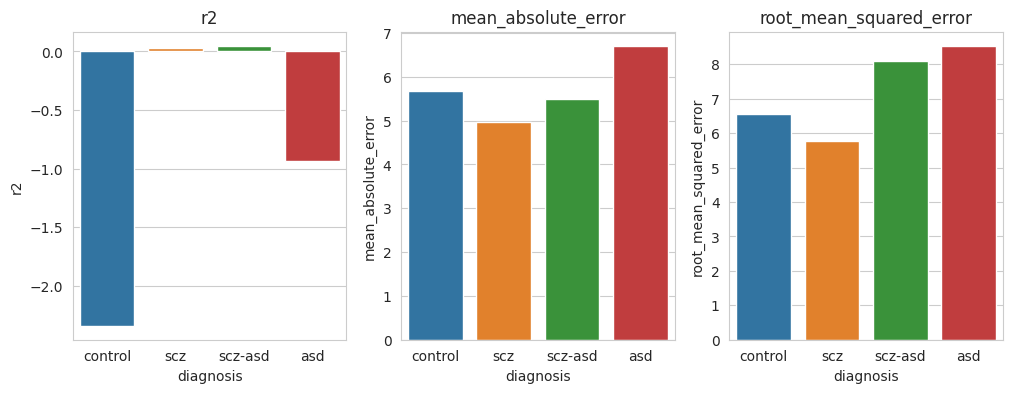

In [11]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(4*3, 4))
    for i, metric in enumerate(["r2", "mean_absolute_error", "root_mean_squared_error"]):
        sns.barplot(data=data_df, x="diagnosis", y=metric, order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[i])
        ax[i].set_title(metric)
plt.show()

## Random permutation predictions

In [12]:
n_permutations = 1000
label = "NSS"
results = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-lrl2_label-{label}_permutation-{i}.csv")) for i in range(n_permutations+1)], axis=0)
results["target"] = results["label"].apply(lambda l: "random" if l != "NSS_permutation-0" else "scores")
results.head()

,label,fold,split,model,scaler,preproc,metric,value,target
0,NSS_permutation-0,0,train,lrl2,False,skeleton,r2,1.000000,scores
1,NSS_permutation-0,0,train,lrl2,False,skeleton,rmse,0.000054,scores
2,NSS_permutation-0,0,train,lrl2,False,skeleton,mae,0.000043,scores
3,NSS_permutation-0,0,test,lrl2,False,skeleton,r2,0.023228,scores
4,NSS_permutation-0,0,test,lrl2,False,skeleton,rmse,8.324045,scores


In [13]:
results.loc[results["label"] == "NSS_permutation-0", ["split", "metric", "value"]].groupby(["split", "metric"]).describe()

value                                                        \
             count      mean           std       min       25%       50%   
split metric                                                               
test  mae     10.0  5.834031  1.431135e+00  4.180320  4.603550  5.810042   
      r2      10.0 -0.099754  1.921041e-01 -0.402742 -0.235772 -0.013551   
      rmse    10.0  7.191356  2.106693e+00  5.013683  5.441581  7.067138   
train mae     10.0  0.000040  1.280990e-05  0.000004  0.000043  0.000045   
      r2      10.0  1.000000  1.822728e-11  1.000000  1.000000  1.000000   
      rmse    10.0  0.000051  1.608230e-05  0.000006  0.000054  0.000058   

                                   
                   75%        max  
split metric                       
test  mae     6.787190   8.614779  
      r2      0.045789   0.127252  
      rmse    8.077180  11.943911  
train mae     0.000046   0.000046  
      r2      1.000000   1.000000  
      rmse    0.000058   0.000059

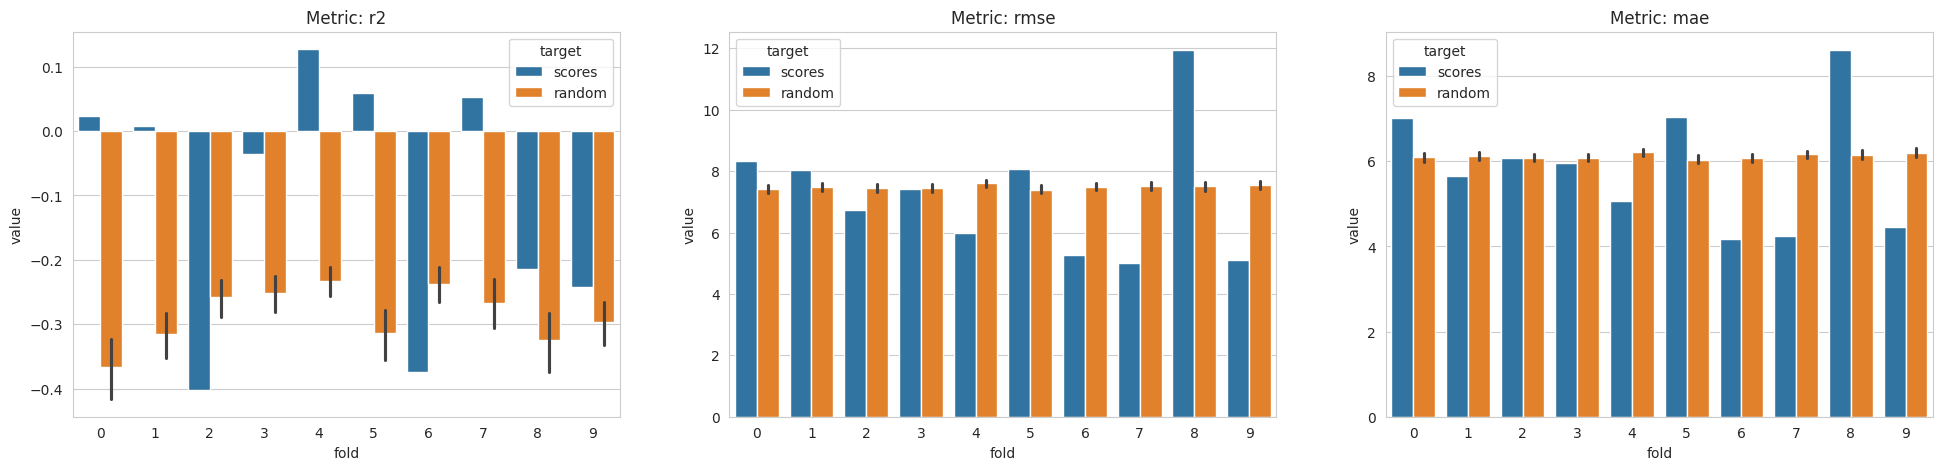

In [14]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(8*3, 5*1))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["split"] == "test")], x="fold", y="value", hue="target", ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")

    plt.show()

## Metadata predictions

In [15]:
labels = ["NSS", "diagnosis", "sex", "age", "skeleton_size", "tiv"]
models = {l: "logreg" if l in ["diagnosis", "sex"] else "lrl2" for l in labels}
results = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-{models[l]}_label-{l}.csv")) for l in labels], axis=0)

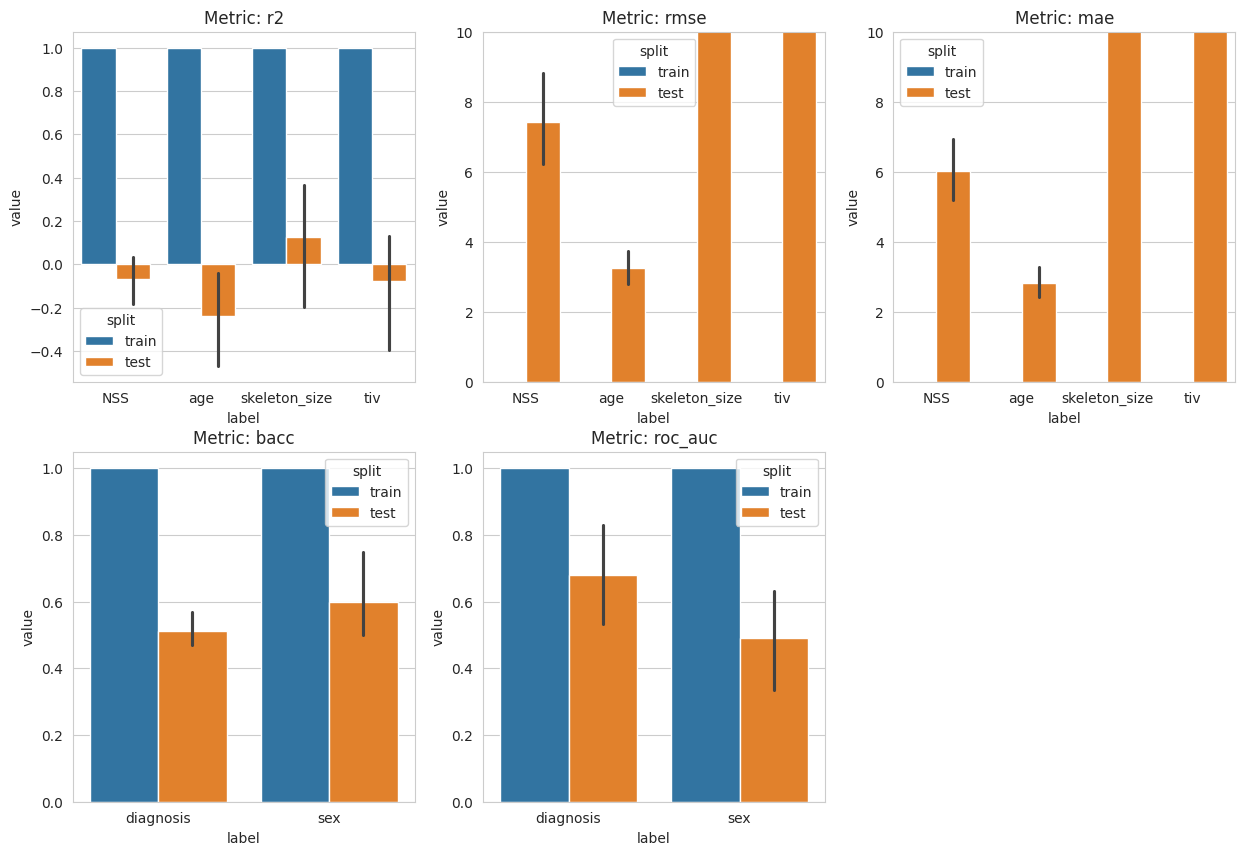

In [16]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["fold"] != 6)], x="label", y="value", hue="split", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 1].set(ylim=(0, 10))
    ax[0, 2].set(ylim=(0, 10))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=results[(results["metric"] == metric)], x="label", y="value", hue="split", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()

# Only NSS score for stratification

In [5]:
# Loading data
saving_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20241007_nss_stratification"
scheme = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/processed/nss_stratified_10_fold_ausz.csv", sep=",")
df = pd.read_csv("/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/data/processed/ausz_t1mri_participants.csv", sep=",")
preproc = "skeleton"
nb_folds = 10

## NSS predictions

In [6]:
label = "NSS"
results = pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-lrl2_label-{label}.csv"), sep=",")
results.loc[results["split"] == "test", ["metric", "value"]].groupby("metric").describe()

value                                                              \
       count      mean       std       min       25%       50%       75%   
metric                                                                     
mae     10.0  5.740329  0.915873  4.949099  5.037448  5.677261  5.811861   
r2      10.0  0.057677  0.098674 -0.126055  0.007615  0.062263  0.114762   
rmse    10.0  7.137735  1.526914  5.854827  6.436881  6.607548  6.954149   

                   
              max  
metric             
mae      7.943972  
r2       0.200263  
rmse    11.078812

In [7]:
df_pred = df[["participant_id", "age", "sex", "diagnosis", "NSS"]].copy(deep=True)
for fold in range(nb_folds):
    df_pred.loc[scheme[f"fold{fold}"] == "test", "y_pred"] = np.load(os.path.join(saving_dir, f"y_pred_label-{label}_preproc-{preproc}_fold-{fold}.npy"))

In [8]:
print(df_pred["y_pred"].min(), df_pred["y_pred"].max(), df_pred["y_pred"].mean(), df_pred["y_pred"].std())

6.990122 15.320864 11.108723 1.8926953


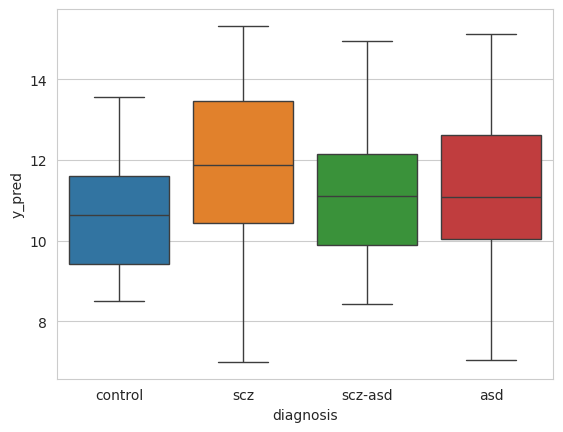

In [9]:
with sns.axes_style("whitegrid"):
    sns.boxplot(data=df_pred, x="diagnosis", y="y_pred", order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"))
plt.show()

In [10]:
data = defaultdict(list)
for diag in ("control", "scz", "scz-asd", "asd"):
    
    r2 = r2_score(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                           y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    mae = mean_absolute_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'])
    rmse = mean_squared_error(y_pred=df_pred.loc[df_pred['diagnosis'] == diag, 'y_pred'],
                                       y_true=df_pred.loc[df_pred['diagnosis'] == diag, 'NSS'],
                                       squared=False)
    print(f"# {diag}")
    print(f"R2:", r2)
    print(f"MAE:", mae)
    print(f"RMSE:", rmse)

    data["diagnosis"].append(diag)
    data["r2"].append(r2)
    data["mean_absolute_error"].append(mae)
    data["root_mean_squared_error"].append(rmse)
data_df = pd.DataFrame(data)

# control
R2: -2.340779780760848
MAE: 5.799044865828294
RMSE: 6.569499839718385
# scz
R2: 0.06244978651059996
MAE: 4.943788488705953
RMSE: 5.68373029636459
# scz-asd
R2: 0.11286344916863322
MAE: 5.300267553329467
RMSE: 7.828229371323616
# asd
R2: -0.9815665248160603
MAE: 6.734829196929931
RMSE: 8.624848250351707


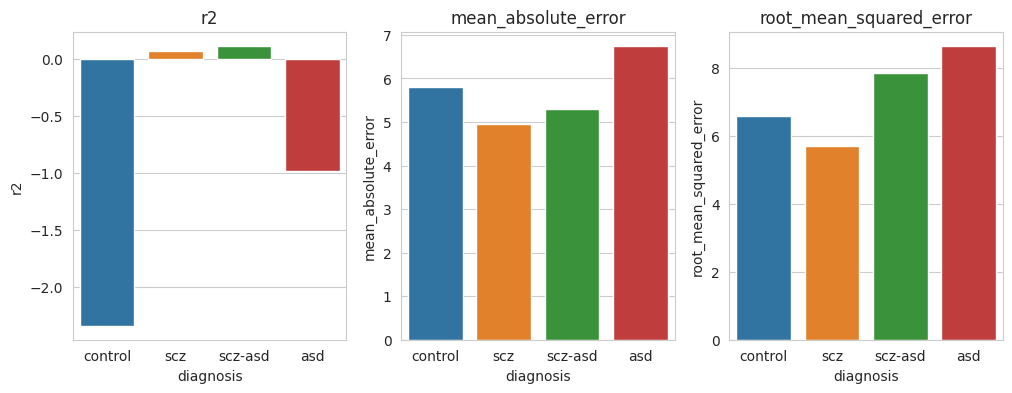

In [11]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(4*3, 4))
    for i, metric in enumerate(["r2", "mean_absolute_error", "root_mean_squared_error"]):
        sns.barplot(data=data_df, x="diagnosis", y=metric, order=("control", "scz", "scz-asd", "asd"), hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax[i])
        ax[i].set_title(metric)
plt.show()

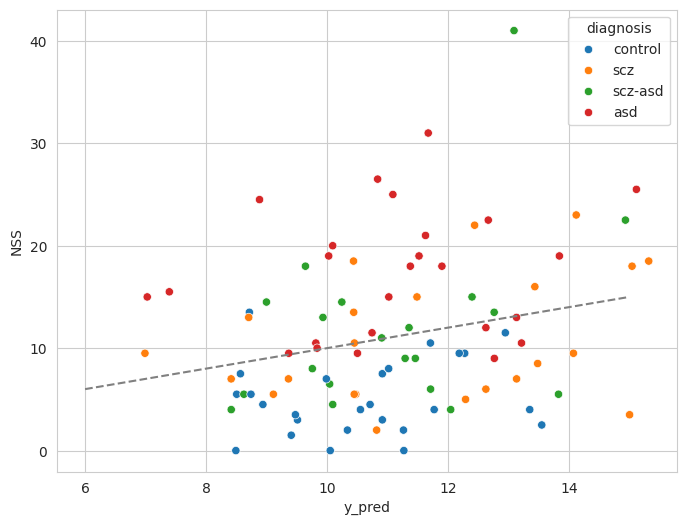

In [12]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.scatterplot(data=df_pred, x="y_pred", y="NSS", hue="diagnosis", hue_order=("control", "scz", "scz-asd", "asd"), ax=ax)
    ax.plot([i for i in range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1])+1)], 
            [i for i in range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1])+1)],
            color="gray", linestyle="--")
plt.show()

## Random permutation predictions

In [14]:
n_permutations = 1000
label = "NSS"
# NB : new saving directory with results with the true y_test
s_dir = "/neurospin/psy_sbox/analyses/2023_pauriau_EarlyBrainMarkersWithContrastiveAnalysis/models/skeleton/20241017_random_permutations"
results = pd.concat([pd.read_csv(os.path.join(s_dir, f"preproc-{preproc}_model-lrl2_label-{label}_permutation-{i}.csv")) for i in range(n_permutations)], axis=0)
results["target"] = results["label"].apply(lambda l: "random" if l != "NSS_permutation-0" else "scores")
results.head()

,label,fold,split,model,scaler,preproc,metric,value,target
0,NSS_permutation-0,0,train,lrl2,False,skeleton,r2,0.999420,scores
1,NSS_permutation-0,0,train,lrl2,False,skeleton,rmse,0.183100,scores
2,NSS_permutation-0,0,train,lrl2,False,skeleton,mae,0.144881,scores
3,NSS_permutation-0,0,test,lrl2,False,skeleton,r2,0.052352,scores
4,NSS_permutation-0,0,test,lrl2,False,skeleton,rmse,6.401272,scores


In [15]:
results.loc[results["label"] == "NSS_permutation-0", ["split", "metric", "value"]].groupby(["split", "metric"]).describe()

value                                                    \
             count      mean       std       min       25%       50%   
split metric                                                           
test  mae     10.0  5.754093  0.909039  5.010235  5.076228  5.648979   
      r2      10.0  0.060791  0.091217 -0.106716  0.020042  0.050896   
      rmse    10.0  7.127592  1.523456  5.940304  6.431512  6.552507   
train mae     10.0  0.142180  0.002801  0.136069  0.141533  0.143158   
      r2      10.0  0.999422  0.000015  0.999400  0.999413  0.999420   
      rmse    10.0  0.180251  0.005986  0.164048  0.179607  0.182131   

                                   
                   75%        max  
split metric                       
test  mae     5.818738   7.981340  
      r2      0.113807   0.194518  
      rmse    6.972234  11.069214  
train mae     0.143713   0.144901  
      r2      0.999431   0.999448  
      rmse    0.183432   0.184225

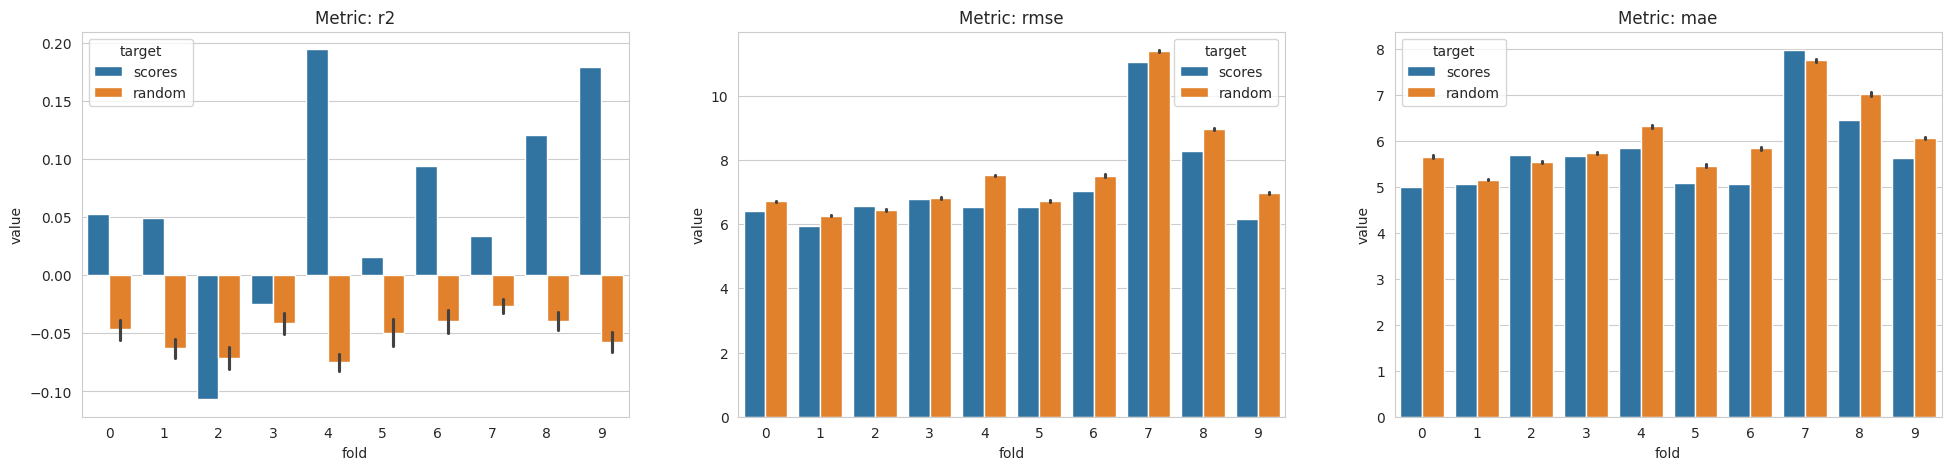

In [16]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1, 3, figsize=(8*3, 5*1))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["split"] == "test")], x="fold", y="value", hue="target", ax=ax[i])
        ax[i].set_title(f"Metric: {metric}")

    plt.show()

## Metadata predictions

In [17]:
labels = ["NSS", "diagnosis", "sex", "age", "skeleton_size", "tiv"]
models = {l: "logreg" if l in ["diagnosis", "sex"] else "lrl2" for l in labels}
results = pd.concat([pd.read_csv(os.path.join(saving_dir, f"preproc-{preproc}_model-{models[l]}_label-{l}.csv")) for l in labels], axis=0)

In [20]:
results.loc[results["split"]=="test", ["label", "metric", "value"]].groupby(["label", "metric"]).describe([0.5])

value                                                    \
                      count         mean         std         min          50%   
label         metric                                                            
NSS           mae      10.0     5.740329    0.915873    4.949099     5.677261   
              r2       10.0     0.057677    0.098674   -0.126055     0.062263   
              rmse     10.0     7.137735    1.526914    5.854827     6.607548   
age           mae      10.0     2.836034    0.705865    2.023410     2.640674   
              r2       10.0    -0.457079    0.486854   -1.314136    -0.225177   
              rmse     10.0     3.324520    0.781305    2.383820     3.067329   
diagnosis     bacc     10.0     0.478571    0.048211    0.357143     0.500000   
              roc_auc  10.0     0.538095    0.228918    0.222222     0.511905   
sex           bacc     10.0     0.550000    0.158114    0.500000     0.500000   
              roc_auc   9.0     0.619048    0.293166    0.238095     0.750000   
skeleton_size mae      10.0  1344.842950  445.743046  781.158997  1313.674438   
              r2       10.0     0.364591    0.098099    0.223268     0.361314   
              rmse     10.0  1633.595270  546.283267  971.874329  1640.301392   
tiv           mae      10.0   116.197135   30.729332   58.210396   118.914555   
              r2       10.0     0.018442    0.120469   -0.158569    -0.009145   
              rmse     10.0   144.824083   26.867321   93.988060   152.449242   

                                    
                               max  
label         metric                
NSS           mae         7.943972  
              r2          0.200263  
              rmse       11.078812  
age           mae         4.399748  
              r2          0.059686  
              rmse        4.962633  
diagnosis     bacc        0.500000  
              roc_auc     0.944444  
sex           bacc        1.000000  
              roc_auc     1.000000  
skeleton_size mae      2066.743408  
              r2          0.530791  
              rmse     2534.460693  
tiv           mae       157.182983  
              r2          0.254857  
              rmse      184.559143

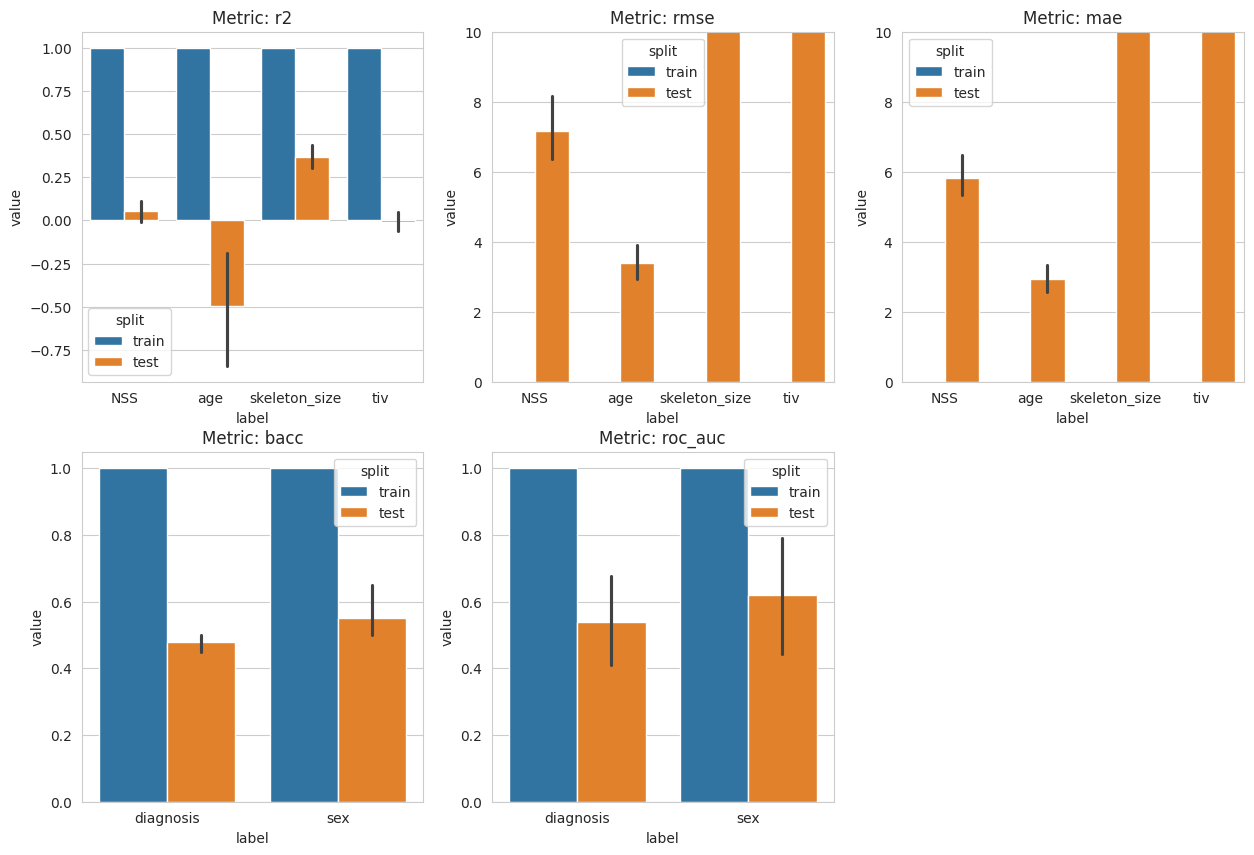

In [ ]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2, 3, figsize=(5*3, 5*2))
    
    for i, metric in enumerate(["r2", "rmse", "mae"]):
        sns.barplot(data=results[(results["metric"] == metric) & (results["fold"] != 6)], x="label", y="value", hue="split", ax=ax[0, i])
        ax[0, i].set_title(f"Metric: {metric}")
    ax[0, 1].set(ylim=(0, 10))
    ax[0, 2].set(ylim=(0, 10))

    for i, metric in enumerate(["bacc", "roc_auc"]):
        sns.barplot(data=results[(results["metric"] == metric)], x="label", y="value", hue="split", ax=ax[1, i])
        ax[1, i].set_title(f"Metric: {metric}")
    ax[1, 2].set_axis_off()

    plt.show()